This is an Image classification exercise. We will play with an expired Kaggle competition, please follow the rule of Kaggle and check the following page for more information https://www.kaggle.com/c/dogs-vs-cats/. After you make the prediction on the testing data, submit your prediction to Kaggle via late submission portal and show your team performance (Name formation of your submission: MSBA.SessionX.Yourname, please replace X and Yourname with the correct string) using the screenshot on the Private Leaderboard, along with the description of your solutions and the codes (ipynb formation is highly encouraged) as the final submission.

## **Download Data from Kaggle Using their API**

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mainakmanojkumarroy","key":"5ce7456a836a8b30f592bb0ad41b6052"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition

 95% 257M/271M [00:03<00:00, 74.8MB/s]
100% 271M/271M [00:03<00:00, 91.0MB/s]
 98% 534M/544M [00:05<00:00, 87.6MB/s]
100% 544M/544M [00:05<00:00, 96.7MB/s]
  0% 0.00/111k [00:00<?, ?B/s]
100% 111k/111k [00:00<00:00, 40.2MB/s]


In [0]:
!mkdir data && unzip test.zip -d data/
!unzip train.zip -d data

## Creating some constants and loading Libraries

In [0]:
PATH = '/content/data/'
IMAGE_SIZE = (224, 224)
EPOCHS = 5

In [3]:
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.layers import Input, Flatten, Dense, Conv2D, MaxPooling2D,Dropout,GlobalAveragePooling2D
from keras.models import Model, Sequential
from keras.optimizers import SGD,RMSprop
import keras

Using TensorFlow backend.


## Creating a dataframe to visualize dataset

In [20]:
# Create DataFrame to visualize dataset
filenames = os.listdir(f'{PATH}train')
labels = []
for name in filenames:
    label = name.split('.')[0]
    if label == 'dog':
        labels.append(1)
    else:
        labels.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'label': labels
})

df.head()

,filename,label
0,cat.330.jpg,0
1,dog.5459.jpg,1
2,dog.321.jpg,1
3,dog.11694.jpg,1
4,cat.5442.jpg,0


#### Checking number of samples from each class

In [21]:
df.pivot_table(index='label', aggfunc=len).sort_values('filename', ascending=False)

,filename
label,
0,12500
1,12500


#### Loading Sample Images

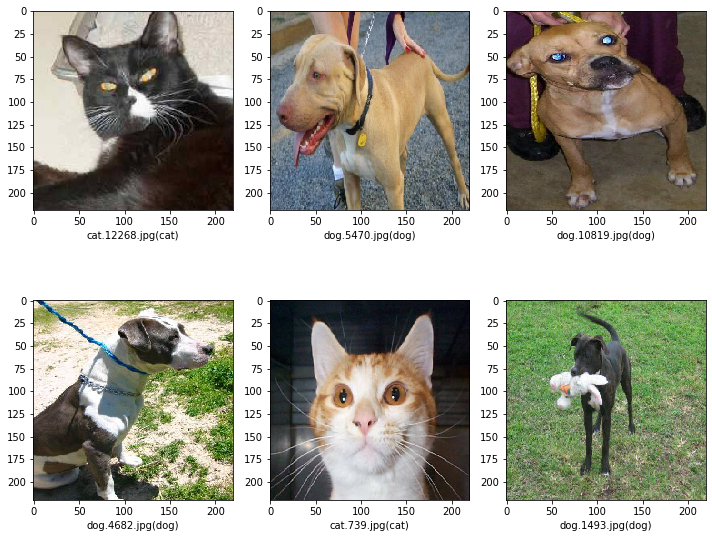

In [0]:
# See sample images
sample_train = df.head(6)
sample_train.head()
plt.figure(figsize=(10, 24))
for index, row in sample_train.iterrows():
    filename = row['filename']
    category = row['label']
    img = load_img(PATH+'/train/'+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

### Creating a baseline CNN model based on VGG16 architecture

In [0]:
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(220, 220, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(2, activation='softmax'))
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

In [0]:
basemodel = define_model()

In [0]:
# Split dataset to validation and train
df['label'] = df['label'].replace({0:'cat', 1:'dog'})

train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [0]:
train_df.shape

(20000, 2)

In [0]:
validate_df.shape

(5000, 2)

In [0]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
 
validate_datagen = ImageDataGenerator(rescale=1./255)
 
# Define the batchsize for train and validation datasets
train_batchsize = 50
validate_batchsize = 50


# Create data generators
train_generator = train_datagen.flow_from_dataframe(train_df, 
                                                    PATH+'/train', 
                                                    x_col = 'filename', 
                                                    y_col = 'label', 
                                                    batch_size=train_batchsize, 
                                                    class_mode='categorical', 
                                                    target_size=IMAGE_SIZE)

validate_generator = validate_datagen.flow_from_dataframe(validate_df, 
                                                          PATH+'/train', 
                                                          x_col = 'filename', 
                                                          y_col = 'label', 
                                                          batch_size=validate_batchsize, 
                                                          class_mode='categorical', 
                                                          target_size=IMAGE_SIZE)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


In [0]:
#from keras.applications import VGG16
# Load the VGG model with trained on ImageNet
vgg_imagenet = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

#Freeze the layers except last 4 layers
for layer in vgg_imagenet.layers[:-4]:
    layer.trainable = False

# Show a summary of the model. Check the number of trainable parameters
#vgg_imagenet.summary()

In [0]:
# Create new model (VGG ImageNet (CNN) + fully-connected layers)
model = Sequential()
 
# Add the VGG ImageNet model
model.add(vgg_imagenet)
 
# Add new FC layers
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['accuracy'])

# Train the model
history = model.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size,
      epochs=2,
      validation_data=validate_generator,
      validation_steps=validate_generator.samples/validate_generator.batch_size,
      verbose=1)

Epoch 1/2
 98/400 [======>.......................] - ETA: 6:27 - loss: 0.5137 - acc: 0.7724

KeyboardInterrupt: ignored

KeyboardInterrupt: ignored

In [0]:
model.save_weights("vgg16_weights.h5")

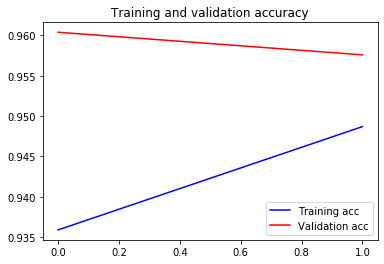

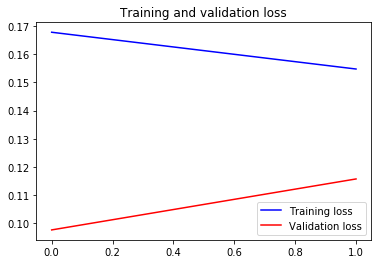

{'acc': [0.9358999974280596, 0.9486999994516373],
 'loss': [0.16785292594926432, 0.15477436675922945],
 'val_acc': [0.9603999972343444, 0.9575999987125396],
 'val_loss': [0.09755353543907404, 0.11567983854562044]}

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()
history.history

## Building a Resnet50 Model

In [0]:
#from keras.applications import VGG16
# Load the VGG model with trained on ImageNet
#vgg_imagenet_pre_trained = VGG16(include_top=False, input_shape=(220, 220, 3))
resnet50 = keras.applications.resnet.ResNet50(include_top=False, weights='imagenet', input_shape=(220, 220, 3))
x = resnet50.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation= 'softmax')(x)
model = Model(inputs = resnet50.input, outputs = predictions)

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Train the model
history = model.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size,
      epochs=8,
      validation_data=validate_generator,
      validation_steps=validate_generator.samples/validate_generator.batch_size,
      verbose=1)

Epoch 1/8
400/400 [==============================] - 606s 2s/step - loss: 0.1821 - acc: 0.9241 - val_loss: 0.2649 - val_acc: 0.8736
Epoch 2/8
400/400 [==============================] - 573s 1s/step - loss: 0.1440 - acc: 0.9405 - val_loss: 0.2181 - val_acc: 0.9086
Epoch 3/8
400/400 [==============================] - 573s 1s/step - loss: 0.1350 - acc: 0.9473 - val_loss: 0.1489 - val_acc: 0.9390
Epoch 4/8
400/400 [==============================] - 573s 1s/step - loss: 0.1233 - acc: 0.9498 - val_loss: 0.5064 - val_acc: 0.7044
Epoch 5/8
400/400 [==============================] - 573s 1s/step - loss: 0.1135 - acc: 0.9545 - val_loss: 0.2636 - val_acc: 0.8746
Epoch 6/8
400/400 [==============================] - 574s 1s/step - loss: 0.1053 - acc: 0.9569 - val_loss: 0.2062 - val_acc: 0.8930
Epoch 7/8
400/400 [==============================] - 575s 1s/step - loss: 0.1011 - acc: 0.9601 - val_loss: 0.1947 - val_acc: 0.9210
Epoch 8/8
400/400 [==============================] - 574s 1s/step - loss: 0.

## Builing a VGG16 based model

In [0]:
PATH = 'data/'

### Splitting data into train-validation datasets

In [0]:
# organize dataset into a useful structure
from os import makedirs
from os import listdir
from shutil import copyfile
from random import seed
from random import random
# create directories
dataset_home = 'dataset_dogs_vs_cats/'
subdirs = ['/data/train/', 'data/test/']
for subdir in subdirs:
	# create label subdirectories
	labeldirs = ['dogs/', 'cats/']
	for labldir in labeldirs:
		newdir = dataset_home + subdir + labldir
		makedirs(newdir, exist_ok=True)
# seed random number generator
seed(1)
# define ratio of pictures to use for validation
val_ratio = 0.25
# copy training dataset images into subdirectories
src_directory = 'data/train/'
for file in listdir(src_directory):
	src = src_directory + '/' + file
	dst_dir = 'data/train/'
	if random() < val_ratio:
		dst_dir = 'data/test/'
	if file.startswith('cat'):
		dst = dataset_home + dst_dir + 'cats/'  + file
		copyfile(src, dst)
	elif file.startswith('dog'):
		dst = dataset_home + dst_dir + 'dogs/'  + file
		copyfile(src, dst)

### Defining the model


In [0]:
#vgg16 model used for transfer learning on the dogs and cats dataset
import sys
from matplotlib import pyplot
from keras.utils import to_categorical
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
def define_model():
	# load model
	model = VGG16(include_top=False, input_shape=(224, 224, 3))
	# mark loaded layers as not trainable
	for layer in model.layers:
		layer.trainable = False
	# add new classifier layers
	flat1 = Flatten()(model.layers[-1].output)
	class1 = Dense(256, activation='relu', kernel_initializer='he_uniform')(flat1)
	output = Dense(1, activation='sigmoid')(class1)
	# define new model
	model = Model(inputs=model.inputs, outputs=output)
	# compile model
	opt = SGD(lr=0.0001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

### Training the model

In [12]:
model = define_model()
	# create data generator
datagen = ImageDataGenerator(featurewise_center=True)
	# specify imagenet mean values for centering
datagen.mean = [123.68, 116.779, 103.939]
	# prepare iterator
train_it = datagen.flow_from_directory('dataset_dogs_vs_cats/data/train/',
class_mode='binary', batch_size=64, target_size=(224, 224))
test_it = datagen.flow_from_directory('dataset_dogs_vs_cats/data/test/',
class_mode='binary', batch_size=64, target_size=(224, 224))
# fit model
history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
validation_data=test_it, validation_steps=len(test_it), epochs=10, verbose=1)

Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.


Epoch 1/10
293/293 [==============================] - 236s 805ms/step - loss: 0.5877 - acc: 0.9570 - val_loss: 0.3742 - val_acc: 0.9706
Epoch 2/10
293/293 [==============================] - 221s 755ms/step - loss: 0.2790 - acc: 0.9769 - val_loss: 0.2358 - val_acc: 0.9726
Epoch 3/10
293/293 [==============================] - 221s 755ms/step - loss: 0.0781 - acc: 0.9827 - val_loss: 0.0825 - val_acc: 0.9732
Epoch 4/10
293/293 [==============================] - 222s 756ms/step - loss: 0.0245 - acc: 0.9939 - val_loss: 0.0855 - val_acc: 0.9748
Epoch 5/10
293/293 [==============================] - 221s 756ms/step - loss: 0.0095 - acc: 0.9984 - val_loss: 0.0947 - val_acc: 0.9752
Epoch 6/10
293/293 [==============================] - 221s 756ms/step - loss: 0.0052 - acc: 0.9996 - val_loss: 0.1084 - val_acc: 0.9756
Epoch 7/10
293/293 [==============================] - 221s 755ms/step - loss: 0.0042 - acc: 0.999

### Visualizing the performance of VGG16 model

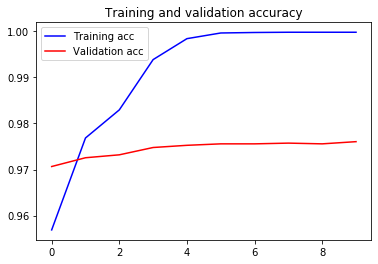

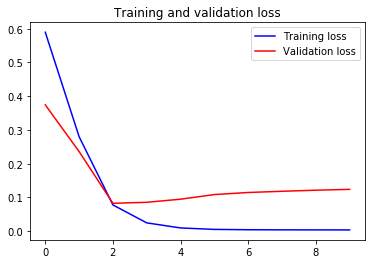

{'acc': [0.9568914799165642,
  0.9768412044713055,
  0.9829384393250042,
  0.9938492806332567,
  0.9983954645130235,
  0.9996256083863722,
  0.9997325774188373,
  0.9997860619350698,
  0.9997860619350698,
  0.9997860619350698],
 'loss': [0.589388735154075,
  0.27985028210861523,
  0.07772014771504519,
  0.024563701390846595,
  0.009539509798141858,
  0.005227709528087322,
  0.004238515364191752,
  0.0039214858984423576,
  0.0037751019517386036,
  0.0036895104619041976],
 'val_acc': [0.9706488972086198,
  0.9725527525156165,
  0.9731873709512819,
  0.9747739170404459,
  0.9752498810090433,
  0.9755671902268761,
  0.9755671902363326,
  0.9757258448357925,
  0.9755671902268761,
  0.9760431540536253],
 'val_loss': [0.3742084109613874,
  0.23579267684817448,
  0.08251090248295774,
  0.08550670716687553,
  0.0947457556736168,
  0.1084381091187828,
  0.11457543146252624,
  0.11817119030017635,
  0.12134691930650099,
  0.12387991886879696]}

In [16]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()
history.history

In [0]:
model.save_weights("VGG16.h5")

In [0]:
model = define_model()

In [0]:
#model.load_weights("VGG16.h5")

### Now using Keras' ImageGenerator to morph images prior to feeding into training to reduce overfitting and increase regularization

In [13]:
model = define_model()
	# create data generator
datagen = ImageDataGenerator(rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
	# specify imagenet mean values for centering
datagen.mean = [123.68, 116.779, 103.939]
	# prepare iterator
validate_datagen = ImageDataGenerator(rescale=1./255)
train_it = datagen.flow_from_directory('dataset_dogs_vs_cats/data/train/',
class_mode='binary', batch_size=64, target_size=(224, 224))
test_it = validate_datagen.flow_from_directory('dataset_dogs_vs_cats/data/test/',
class_mode='binary', batch_size=64, target_size=(224, 224))
# fit model
history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
validation_data=test_it, validation_steps=len(test_it), epochs=10, verbose=1)

Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.
Epoch 1/10
293/293 [==============================] - 361s 1s/step - loss: 0.4423 - acc: 0.7858 - val_loss: 0.2438 - val_acc: 0.9020
Epoch 2/10
293/293 [==============================] - 345s 1s/step - loss: 0.3206 - acc: 0.8600 - val_loss: 0.2254 - val_acc: 0.9035
Epoch 3/10
293/293 [==============================] - 342s 1s/step - loss: 0.2821 - acc: 0.8753 - val_loss: 0.1892 - val_acc: 0.9243
Epoch 4/10
293/293 [==============================] - 343s 1s/step - loss: 0.2613 - acc: 0.8872 - val_loss: 0.2300 - val_acc: 0.9020
Epoch 5/10
293/293 [==============================] - 344s 1s/step - loss: 0.2665 - acc: 0.8846 - val_loss: 0.2018 - val_acc: 0.9170
Epoch 6/10
293/293 [==============================] - 347s 1s/step - loss: 0.2506 - acc: 0.8931 - val_loss: 0.1734 - val_acc: 0.9308
Epoch 7/10
293/293 [==============================] - 345s 1s/step - loss: 0.2451 - acc: 0.8932 - val_loss: 0.2683 - 

Looks like the regularization did not work well, the images in validation set are very similar to that of the train set. As the photos are very similar, it is fine to overfit the model for this case. 

### Now only training the last 4 layers of the VG16 model, instead of only using the Fully Connceted Dense Layers.

In [29]:
def define_model():
	# load model
	model = VGG16(include_top=False, input_shape=(224, 224, 3))
	# mark loaded layers as not trainable
	for layer in model.layers[:-4]:
		layer.trainable = False
	# add new classifier layers
	flat1 = Flatten()(model.layers[-1].output)
	class1 = Dense(256, activation='relu', kernel_initializer='he_uniform')(flat1)
	output = Dense(1, activation='sigmoid')(class1)
	# define new model
	model = Model(inputs=model.inputs, outputs=output)
	# compile model
	opt = SGD(lr=0.0001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

modelPartial = define_model()
	# create data generator
datagen = ImageDataGenerator(featurewise_center=True)
	# specify imagenet mean values for centering
datagen.mean = [123.68, 116.779, 103.939]
	# prepare iterator
train_it = datagen.flow_from_directory('dataset_dogs_vs_cats/data/train/',
class_mode='binary', batch_size=64, target_size=(224, 224))
test_it = datagen.flow_from_directory('dataset_dogs_vs_cats/data/test/',
class_mode='binary', batch_size=64, target_size=(224, 224))
# fit model
history = modelPartial.fit_generator(train_it, steps_per_epoch=len(train_it),
validation_data=test_it, validation_steps=len(test_it), epochs=10, verbose=1)

Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.
Epoch 1/10
293/293 [==============================] - 241s 824ms/step - loss: 0.2815 - acc: 0.9583 - val_loss: 0.1077 - val_acc: 0.9722
Epoch 2/10
293/293 [==============================] - 238s 812ms/step - loss: 0.0376 - acc: 0.9905 - val_loss: 0.1050 - val_acc: 0.9727
Epoch 3/10
293/293 [==============================] - 238s 813ms/step - loss: 0.0091 - acc: 0.9991 - val_loss: 0.1064 - val_acc: 0.9762
Epoch 4/10
293/293 [==============================] - 238s 813ms/step - loss: 0.0070 - acc: 0.9996 - val_loss: 0.1071 - val_acc: 0.9760
Epoch 5/10
293/293 [==============================] - 239s 815ms/step - loss: 0.0067 - acc: 0.9996 - val_loss: 0.1087 - val_acc: 0.9765
Epoch 6/10
293/293 [==============================] - 239s 815ms/step - loss: 0.0065 - acc: 0.9996 - val_loss: 0.1100 - val_acc: 0.9765
Epoch 7/10
293/293 [==============================] - 239s 815ms/step - loss: 0.0064 - acc: 0.9996 

In [0]:
modelPartial.save_weights("llast4.h5")

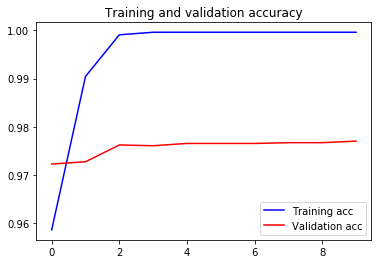

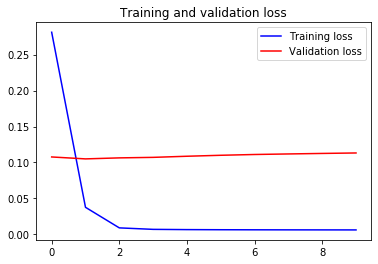

In [31]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

Training the last 4 layers seemed to perform, well, well add some regularization to it, in the form of drop out.

In [41]:
dropout2 = Dropout(0.85)
from keras import regularizers
def define_model():
	# load model
	model = VGG16(include_top=False, input_shape=(224, 224, 3))
	# mark loaded layers as not trainable
	for layer in model.layers[:-4]:
		layer.trainable = False
	# add new classifier layers
	flat1 = Flatten()(model.layers[-1].output)
	class1 = Dense(256, activation='relu', kernel_initializer='he_uniform',
                kernel_regularizer=regularizers.l2(0.01))(flat1)
	output = Dense(1, activation='sigmoid')(class1)
	# define new model
	model = Model(inputs=model.inputs, outputs=output)
	# compile model
	opt = SGD(lr=0.0001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

modelPartial = define_model()
	# create data generator
datagen = ImageDataGenerator(featurewise_center=True)
	# specify imagenet mean values for centering
datagen.mean = [123.68, 116.779, 103.939]
	# prepare iterator
train_it = datagen.flow_from_directory('dataset_dogs_vs_cats/data/train/',
class_mode='binary', batch_size=64, target_size=(224, 224))
test_it = datagen.flow_from_directory('dataset_dogs_vs_cats/data/test/',
class_mode='binary', batch_size=64, target_size=(224, 224))
# fit model
history = modelPartial.fit_generator(train_it, steps_per_epoch=len(train_it),
validation_data=test_it, validation_steps=len(test_it), epochs=10, verbose=1)

Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.
Epoch 1/10
293/293 [==============================] - 242s 827ms/step - loss: 5.3212 - acc: 0.9646 - val_loss: 5.1880 - val_acc: 0.9726
Epoch 2/10
293/293 [==============================] - 239s 816ms/step - loss: 5.0810 - acc: 0.9922 - val_loss: 5.1305 - val_acc: 0.9729
Epoch 3/10
293/293 [==============================] - 239s 815ms/step - loss: 4.9938 - acc: 0.9981 - val_loss: 5.0590 - val_acc: 0.9746
Epoch 4/10
293/293 [==============================] - 239s 815ms/step - loss: 4.9280 - acc: 0.9996 - val_loss: 5.0041 - val_acc: 0.9760
Epoch 5/10
293/293 [==============================] - 239s 815ms/step - loss: 4.8702 - acc: 0.9997 - val_loss: 4.9471 - val_acc: 0.9762
Epoch 6/10
293/293 [==============================] - 239s 816ms/step - loss: 4.8134 - acc: 0.9997 - val_loss: 4.8914 - val_acc: 0.9765
Epoch 7/10
293/293 [==============================] - 239s 816ms/step - loss: 4.7573 - acc: 0.9997 

In [0]:
modelPartial.save_weights("partialWithl2.h5")

### Training on Entire Dataset

In [0]:
def define_model():
	# load model
	model = VGG16(include_top=False, input_shape=(224, 224, 3))
	# mark loaded layers as not trainable
	for layer in model.layers:
		layer.trainable = False
	# add new classifier layers
	flat1 = Flatten()(model.layers[-1].output)
	class1 = Dense(256, activation='relu', kernel_initializer='he_uniform')(flat1)
	output = Dense(1, activation='sigmoid')(class1)
	# define new model
	model = Model(inputs=model.inputs, outputs=output)
	# compile model
	opt = SGD(lr=0.0001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

In [0]:
# create directories
dataset_home = 'finalize_dogs_vs_cats/'
# create label subdirectories
labeldirs = ['dogs/', 'cats/']
for labldir in labeldirs:
	newdir = dataset_home + labldir
	makedirs(newdir, exist_ok=True)
# copy training dataset images into subdirectories
src_directory = 'data/train/'
for file in listdir(src_directory):
	src = src_directory + '/' + file
	if file.startswith('cat'):
		dst = dataset_home + 'cats/'  + file
		copyfile(src, dst)
	elif file.startswith('dog'):
		dst = dataset_home + 'dogs/'  + file
		copyfile(src, dst)

In [24]:
model = define_model()
	# create data generator
datagen = ImageDataGenerator(featurewise_center=True)
	# specify imagenet mean values for centering
datagen.mean = [123.68, 116.779, 103.939]
	# prepare iterator
train_it = datagen.flow_from_directory('finalize_dogs_vs_cats/',
class_mode='binary', batch_size=64, target_size=(224, 224))
# fit model
history = model.fit_generator(train_it, steps_per_epoch=len(train_it), epochs=10, verbose=1)

Found 25000 images belonging to 2 classes.
Epoch 1/10
391/391 [==============================] - 225s 577ms/step - loss: 0.3239 - acc: 0.9626
Epoch 2/10
391/391 [==============================] - 221s 564ms/step - loss: 0.0903 - acc: 0.9883
Epoch 3/10
391/391 [==============================] - 220s 564ms/step - loss: 0.0398 - acc: 0.9954
Epoch 4/10
391/391 [==============================] - 221s 565ms/step - loss: 0.0279 - acc: 0.9979
Epoch 5/10
391/391 [==============================] - 221s 565ms/step - loss: 0.0255 - acc: 0.9983
Epoch 6/10
391/391 [==============================] - 221s 565ms/step - loss: 0.0253 - acc: 0.9984
Epoch 7/10
391/391 [==============================] - 221s 565ms/step - loss: 0.0252 - acc: 0.9984
Epoch 8/10
391/391 [==============================] - 222s 567ms/step - loss: 0.0252 - acc: 0.9984
Epoch 9/10
391/391 [==============================] - 221s 566ms/step - loss: 0.0252 - acc: 0.9984
Epoch 10/10
391/391 [==============================] - 221s 566ms/

In [0]:
model.save_weights("VG16FullTraining.h5")

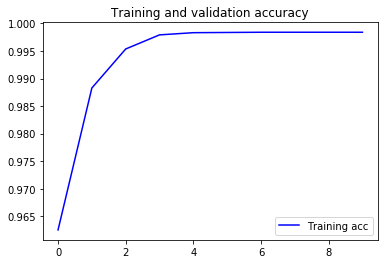

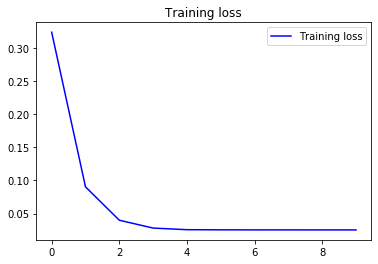

In [28]:
import matplotlib.pyplot as plt
acc = history.history['acc']
#val_acc = history.history['val_acc']
loss = history.history['loss']
#val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
#plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
#plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training loss')
plt.legend()
plt.show()

## Training Last 4 Layers with Regularization on entire data set

In [4]:
dropout2 = Dropout(0.85)
from keras import regularizers
def define_model():
	# load model
	model = VGG16(include_top=False, input_shape=(224, 224, 3))
	# mark loaded layers as not trainable
	for layer in model.layers[:-4]:
		layer.trainable = False
	# add new classifier layers
	flat1 = Flatten()(model.layers[-1].output)
	class1 = Dense(256, activation='relu', kernel_initializer='he_uniform',
                kernel_regularizer=regularizers.l2(0.01))(flat1)
	output = Dense(1, activation='sigmoid')(class1)
	# define new model
	model = Model(inputs=model.inputs, outputs=output)
	# compile model
	opt = SGD(lr=0.0001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

modelPartial = define_model()
	# create data generator
datagen = ImageDataGenerator(featurewise_center=True)
	# specify imagenet mean values for centering
datagen.mean = [123.68, 116.779, 103.939]
	# prepare iterator
train_it = datagen.flow_from_directory('finalize_dogs_vs_cats/',
class_mode='binary', batch_size=64, target_size=(224, 224))
# fit model
history = modelPartial.fit_generator(train_it, steps_per_epoch=len(train_it), epochs=10, verbose=1)













Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Found 25000 images belonging to 2 classes.


Epoch 1/10
391/391 [==============================] - 261s 667ms/step - loss: 5.2931 - acc: 0.9641
Epoch 2/10
391/391 [==============================] - 246s 628ms/step - loss: 5.0326 - acc: 0.9933
Epoch 3/10
391/391 [==============================] - 246s 629ms/step - loss: 4.9347 - acc: 0.9992
Epoch 4/10
391/391 [==============================] - 246s 629ms/step - loss: 4.8557 - acc: 0.9996
Epoch 5/10
391/391 [==============================] - 246s 629ms/step - loss: 4.7800 - acc: 0.9996
Epoch 6/10
391/391 [==============================] - 246s 630ms/step - loss: 4.7058 - acc: 0.9996
Epoch 7/10
391/391 [==============================] - 247s 631ms/step - loss: 4.6327 - acc: 0.9997
Epoch 8/10
391/391 [==============================] - 247s 631ms/step - loss: 4.5608 - acc: 0.9997
Epoch 9/10
391/391 [==============================] - 246

This model gives very good resutls, now will use this to create test set results

In [0]:
modelPartial.save_weights("finalmodel.h5")

In [0]:
modelPartial.save("finalModelFUllModel.h5")

In [0]:
submission = pd.read_csv("sample_submission.csv")

Creating function that will apply same transform to image as the keras imagetransformer

In [0]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model
def load_image(filename):
	# load the image
	img = load_img(filename, target_size=(224, 224))
	# convert to array
	img = img_to_array(img)
	# reshape into a single sample with 3 channels
	img = img.reshape(1, 224, 224, 3)
	# center pixel data
	img = img.astype('float32')
	img = img - [123.68, 116.779, 103.939]
	return img

def run_example(filename):
	# load the image
	img = load_image(filename)
	# load model
	#model = load_model('final_model_reg.h5')
	# predict the class
	prediction = modelPartial.predict(img)
	return prediction

In [0]:
submission['label'] = submission['id'].apply(lambda data: run_example('data/test/'+str(data)+'.jpg')[0][0] )
submission.to_csv("finalSubmit.csv")

In [15]:
submission

,id,label
0,1,1.0
1,2,1.0
2,3,1.0
3,4,1.0
4,5,0.0
...,...,...
12495,12496,0.0
12496,12497,0.0
12497,12498,1.0
12498,12499,1.0


In [1]:
submission

NameError: ignored

In [54]:
submission

,id,label
0,1,0.5
1,2,0.5
2,3,0.5
3,4,0.5
4,5,0.5
...,...,...
12495,12496,0.5
12496,12497,0.5
12497,12498,0.5
12498,12499,0.5
